<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/Evaluation/FinalEvaluation12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

def make_atopy_dataframe():
    paths = []
    dataset_gubuns = []
    gan_gubuns = []
    label_gubuns = []
    # os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
    # atopy-1 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
    # atopy-1 밑으로 /train/, /val/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)

    for dirname, _, filenames in os.walk('/content/drive/MyDrive/data_64_all_eval'):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
              

                # 파일의 절대 경로에 li가 있을 경우 해당 파일은 태선화 이미지 파일이고, red일 경우는 홍진 이미지 파일임 scratch는 긁은 상처  
                if 'li1' in file_path:
                    label_gubuns.append('li1')
                elif 'li2' in file_path:
                    label_gubuns.append('li2')
                elif 'li3' in file_path:
                    label_gubuns.append('li3')
                elif 'red1' in file_path:
                    label_gubuns.append('red1')
                elif 'red2' in file_path:
                    label_gubuns.append('red2')
                elif 'red3' in file_path:
                    label_gubuns.append('red3')
                elif 'scratch1' in file_path:
                    label_gubuns.append('scratch1')
                elif 'scratch2' in file_path:
                    label_gubuns.append('scratch2')
                elif 'scratch3' in file_path:
                    label_gubuns.append('scratch3')
                else: label_gubuns.append('N/A')
    
    data_df = pd.DataFrame({'path':paths,  'label':label_gubuns, })
    return data_df

In [3]:
pd.set_option('display.max_colwidth', 200)
data_df = make_atopy_dataframe()
print('data_df shape:', data_df.shape)
data_df.head()

data_df shape: (600, 2)


,path,label
0,/content/drive/MyDrive/data_64_all_eval/li2/K-523.jpg,li2
1,/content/drive/MyDrive/data_64_all_eval/li2/K-196.jpg,li2
2,/content/drive/MyDrive/data_64_all_eval/li2/K-209.jpg,li2
3,/content/drive/MyDrive/data_64_all_eval/li2/K-083.jpg,li2
4,/content/drive/MyDrive/data_64_all_eval/li2/K-121.jpg,li2


In [4]:
import albumentations as A

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 

data_image_filenames = data_df['path'].values
data_image_labels = data_df['label'].values


In [5]:
data_df.shape

(600, 2)

In [6]:
data_image_filenames.shape

(600,)

In [7]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2
# 배치 크기와 이미지 크기를 전역 변수로 선언 
BATCH_SIZE = 8
IMAGE_SIZE = 64
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class atopyScale_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        # train data의 경우 
        self.shuffle = shuffle
        self.pre_func = pre_func
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            if self.pre_func is not None:
              image = self.pre_func(image)           
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

(8, 64, 64, 3) (8,)
[[[[197. 144. 140.]
   [189. 136. 132.]
   [189. 136. 132.]
   ...
   [158. 117. 113.]
   [152. 113. 108.]
   [175. 136. 131.]]

  [[185. 132. 128.]
   [200. 147. 143.]
   [206. 153. 149.]
   ...
   [159. 118. 114.]
   [148. 109. 104.]
   [166. 127. 122.]]

  [[190. 139. 135.]
   [205. 154. 150.]
   [192. 141. 137.]
   ...
   [162. 121. 117.]
   [156. 115. 111.]
   [172. 131. 127.]]

  ...

  [[163. 118. 115.]
   [157. 112. 109.]
   [154. 109. 106.]
   ...
   [158. 112. 112.]
   [141.  95.  95.]
   [131.  85.  85.]]

  [[183. 138. 135.]
   [154. 109. 106.]
   [165. 120. 117.]
   ...
   [156. 110. 110.]
   [145.  99.  99.]
   [142.  96.  96.]]

  [[177. 132. 129.]
   [152. 107. 104.]
   [163. 118. 115.]
   ...
   [133.  87.  87.]
   [153. 107. 107.]
   [176. 130. 130.]]]


 [[[155. 127. 141.]
   [151. 123. 135.]
   [152. 122. 134.]
   ...
   [110.  78.  81.]
   [118.  86.  89.]
   [115.  85.  87.]]

  [[152. 124. 138.]
   [148. 120. 134.]
   [150. 120. 132.]
   ...
 

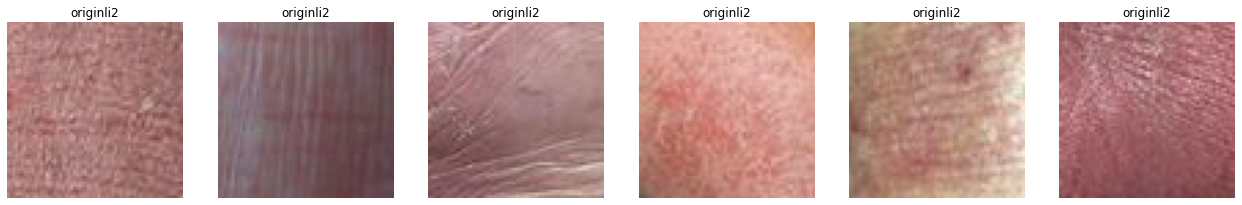

In [8]:
atopyScale_ds = atopyScale_Dataset(data_image_filenames, data_image_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False)
images_batch_scale = next(iter(atopyScale_ds))[0]
labels_batch_scale = next(iter(atopyScale_ds))[1]
print(images_batch_scale.shape, labels_batch_scale.shape)
print(images_batch_scale[0:2])
import matplotlib.pyplot as plt
%matplotlib inline 

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i]) 
        
show_grid_images(images_batch_scale, ncols=6, title='origin' + labels_batch_scale)

In [9]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

In [10]:
myAtopy_ds = atopyScale_Dataset(data_image_filenames, data_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=None, shuffle=False, pre_func=xcp_preprocess_input)

In [11]:
pd.factorize(data_df['label'])[0].shape

(600,)

In [12]:
pd.factorize(data_df['label'])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [13]:
from sklearn.model_selection import train_test_split

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 

data_path = data_df['path'].values

data_image_label = data_df['label'].values
data_label = pd.get_dummies(data_df['label']).values


train_path, test_path, train_label, test_label = train_test_split(data_path, data_label, test_size=0.2, random_state=2021)
tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.2, random_state=2021)

print('학습용 path shape:', tr_path.shape, '검증용 path shape:', val_path.shape, 
      '학습용 label shape:', tr_label.shape, '검증용 label shape:', val_label.shape)
print('테스트 path shape:' , test_path.shape, 'test label shape:', test_label.shape)

학습용 path shape: (384,) 검증용 path shape: (96,) 학습용 label shape: (384, 9) 검증용 label shape: (96, 9)
테스트 path shape: (120,) test label shape: (120, 9)


In [14]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = atopyScale_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=None, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = atopyScale_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)
test_ds = atopyScale_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
test_image_batch = next(iter(test_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)

print(tr_image_batch[:1])
print(val_image_batch[:1])
print(test_image_batch[:1])

(8, 64, 64, 3) (8, 64, 64, 3)
[[[[ 0.082353   -0.2862745  -0.42745095]
   [ 0.10588241 -0.27843136 -0.41176468]
   [ 0.11372554 -0.30196077 -0.44313723]
   ...
   [ 0.20784318 -0.00392157 -0.16862744]
   [ 0.23921573 -0.03529412 -0.19215685]
   [ 0.20784318 -0.08235294 -0.23137254]]

  [[ 0.12941182 -0.27058822 -0.40392154]
   [ 0.05098045 -0.3490196  -0.4823529 ]
   [ 0.082353   -0.35686272 -0.49019605]
   ...
   [ 0.20000005 -0.01960784 -0.18431371]
   [ 0.21568632 -0.05882353 -0.20784312]
   [ 0.20000005 -0.09019607 -0.23921567]]

  [[ 0.082353   -0.372549   -0.4823529 ]
   [ 0.05882359 -0.3960784  -0.5058824 ]
   [ 0.05882359 -0.40392154 -0.5294118 ]
   ...
   [ 0.33333337  0.09019613 -0.06666666]
   [ 0.20784318 -0.06666666 -0.21568626]
   [ 0.13725495 -0.16862744 -0.30196077]]

  ...

  [[ 0.19215691 -0.1372549  -0.3098039 ]
   [ 0.17647064 -0.15294117 -0.32549018]
   [ 0.15294123 -0.17647058 -0.3490196 ]
   ...
   [ 0.20000005 -0.08235294 -0.25490195]
   [ 0.14509809 -0.14509803

In [15]:
#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.layers import Concatenate

In [16]:
def inception_A_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_3x3x3_reduce, filters_3x3x3, filters_avg_pool,
                      name=None, strides=1):
    '''
    x: 입력 Tensor
    filters_1x1: 단독 1x1 필터수
    filters_3x3_reduce: 3x3 Conv 적용 전 1x1 Conv 필터수
    filters_3x3: 3x3 Conv 필터수
    filters_3x3x3_reduce: 3x3x3 Conv 적용 전 1x1 Conv 필터수
    filters_3x3x3: 3x3x3 Conv 필터수
    filters_avg_pool : global average pooling 이 후 1x1필터 수 
    
    '''
    
    # 첫번째 1x1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', strides=strides)(x)

    # 3x3 적용 전 1x1 conv -> 3x3 Conv
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',strides=1)(conv_3x3)

    # 3x3, 3x3 적용 전 1x1 Conv -> 3x3 Conv
    conv_3x3x3 = Conv2D(filters_3x3x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x3x3 = Conv2D(filters_3x3x3, (3, 3), padding='same', activation='relu',strides=1)(conv_3x3x3)
    conv_3x3x3 = Conv2D(filters_3x3x3, (3, 3), padding='same', activation='relu',strides=1)(conv_3x3x3)

    avg_pool = AveragePooling2D(padding="same", pool_size=3, strides=strides)(x)
    avg_pool = Conv2D(filters_avg_pool, (1, 1), padding='same', activation='relu',strides=1)(avg_pool)
    # 단독 1x1 결과, 3x3 결과, 3x3x3 결과, AvgPool이후 1x1 결과 feature map을 채널 기준으로 Concat 적용. 
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_3x3x3, avg_pool])
    return output

In [17]:
def inception_B_module(x, filters_1x1, filters_2_7x7_reduce, filters_2_1x7, filters_2_7x1,filters_3_7x1x1x7_reduce, filters_3_1x7_1,filters_3_7x1_2, filters_3_1x7_3, filters_3_7x1_4, 
                     filters_avg_pool, name=None, strides=1):
    '''
    x: 입력 Tensor
    filters_1x1: 단독 1x1 필터수
    filters_7x7_reduce: 1x7 1x7 Conv 적용 전 1x1 Conv 필터수
    
    '''
    
    # 첫번째 1x1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', strides=strides)(x)
    # 7x7 적용 전 1x1 conv -> 7x7 Conv
    conv_7x7 = Conv2D(filters_2_7x7_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_7x7 = Conv2D(filters_2_1x7, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7)
    conv_7x7 = Conv2D(filters_2_7x1, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7)

    # 7x7x7, 7x7x7 적용 전 1x1 Conv -> 7x7x7 Conv
    conv_7x7x7 = Conv2D(filters_3_7x1x1x7_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_7x7x7 = Conv2D(filters_3_1x7_1, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7x7)
    conv_7x7x7 = Conv2D(filters_3_7x1_2, (7, 1), padding='same', activation='relu',strides=1)(conv_7x7x7)
    conv_7x7x7 = Conv2D(filters_3_1x7_3, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7x7)
    conv_7x7x7 = Conv2D(filters_3_7x1_4, (7, 1), padding='same', activation='relu',strides=1)(conv_7x7x7)

    # Average pooling 부분 
    avg_pool = AveragePooling2D(padding="same", pool_size=3, strides=strides )(x)
    avg_pool = Conv2D(filters_avg_pool, (1, 1), padding='same', activation='relu',strides=1)(avg_pool)
    # 단독 1x1 결과, 3x3 결과, 5x5 결과, pool이후 1x1 결과 feature map을 채널 기준으로 Concat 적용. 
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_7x7, conv_7x7x7, avg_pool])
    return output

In [18]:
def inception_C_module(x, filters_1x1, filters_2_3x11x3_reduce, filters_2_1x3, filters_2_3x1,filters_3_3x11x3_reduce, filters_3_1x3_1,filters_3_3x1_2, filters_3_1x3_3, filters_3_3x1_4, 
                     filters_avg_pool, name=None, strides=1):
    
    # 첫번째 1x1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',strides=strides)(x)

    # 3x1 1x3 적용 전 1x1 conv -> 3x1 1x3 분기 Conv
    conv_3x11x3 = Conv2D(filters_2_3x11x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x11x3_1 = Conv2D(filters_2_1x3, (1, 3), padding='same', activation='relu',strides=1)(conv_3x11x3)
    conv_3x11x3_2 = Conv2D(filters_2_3x1, (3, 1), padding='same', activation='relu',strides=1)(conv_3x11x3)
    #conv_3x11x3_3 = Concatenate(axis=-1, name=name)([conv_3x11x3_1, conv_3x11x3_2])

    # 1x3 3x1 1x3 3x1  적용 전 1x1 Conv -> 1x3 3x1 하고 분기 conv
    conv_3x11x3x2 = Conv2D(filters_3_3x11x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x11x3x2 = Conv2D(filters_3_1x3_1, (1, 3), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    conv_3x11x3x2 = Conv2D(filters_3_3x1_2, (3, 1), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    conv_3x11x3x2_1 = Conv2D(filters_3_1x3_3, (1, 3), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    conv_3x11x3x2_2 = Conv2D(filters_3_3x1_4, (3, 1), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    #conv_3x11x3x2_3 = Concatenate(axis=-1, name=name)([conv_3x11x3x2_1, conv_3x11x3x2_2])

    # Global Average pooling 부분 
    avg_pool = AveragePooling2D(padding="same", pool_size=3, strides=strides)(x)
    avg_pool = Conv2D(filters_avg_pool, (1, 1), padding='same', activation='relu',strides=1)(avg_pool)
    # 단독 1x1 결과, 3x3 결과, 5x5 결과, pool이후 1x1 결과 feature map을 채널 기준으로 Concat 적용. 
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x11x3_1, conv_3x11x3_2, conv_3x11x3x2_1,conv_3x11x3x2_2, avg_pool])
    return output

In [19]:
#convolution 연산을 수행하는 함수 BatchNormalization 까지 수행한다. 

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [20]:
def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [21]:
#entry Flow ReLu()함수는 따로 수행해주었다. 


def entry_flow(x):
    
    #feature map 절반으로 줄음 strides=2 때문
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    #feature map 크기 줄어들음 strides=2
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    #feature map 56
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    #x = inception_A_module(x, filters_1x1=256, filters_3x3_reduce=128, filters_3x3=96, filters_3x3x3_reduce=128, filters_3x3x3=96, filters_avg_pool=96)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = inception_A_module(tensor, filters_1x1=64, filters_3x3_reduce=128, 
                                filters_3x3=64, filters_3x3x3_reduce=128, filters_3x3x3=64, 
                               filters_avg_pool=64, strides=2)
    #tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    #Add는 차원까지 같아야함 
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    #tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    tensor = inception_B_module(tensor, filters_1x1=182, filters_2_7x7_reduce=128, filters_2_1x7=128, filters_2_7x1=182,filters_3_7x1x1x7_reduce=128, filters_3_1x7_1=128,filters_3_7x1_2=128, filters_3_1x7_3=128, filters_3_7x1_4=182, 
                     filters_avg_pool=182, name=None, strides=2)
    x = Add()([tensor,x])
    return x

In [22]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        #x = inception_C_module(x, filters_1x1=256, filters_2_3x11x3_reduce=384, filters_2_1x3=256, filters_2_3x1=256,filters_3_3x11x3_reduce=384, filters_3_1x3_1=448,filters_3_3x1_2=512, filters_3_1x3_3=256, filters_3_3x1_4=256, 
                     #filters_avg_pool=256, name=None)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        #tensor = inception_B_module(tensor, filters_1x1=182, filters_2_7x7_reduce=128, filters_2_1x7=128, filters_2_7x1=182,filters_3_7x1x1x7_reduce=128, filters_3_1x7_1=128,filters_3_7x1_2=128, filters_3_1x7_3=128, filters_3_7x1_4=182, 
                     #filters_avg_pool=182, name=None, strides=1)
        tensor = Add()([tensor,x])
        
    return tensor

In [23]:
# exit flow

def exit_flow(tensor, n_classes):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    # tensor = inception_C_module(tensor, filters_1x1=256, filters_2_3x11x3_reduce=384, filters_2_1x3=256, filters_2_3x1=256,filters_3_3x11x3_reduce=384, filters_3_1x3_1=448,filters_3_3x1_2=512, filters_3_1x3_3=256, filters_3_3x1_4=256, 
    #                  filters_avg_pool=256, name=None, strides=2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    tensor = inception_C_module(tensor, filters_1x1=256, filters_2_3x11x3_reduce=384, filters_2_1x3=256, filters_2_3x1=256,filters_3_3x11x3_reduce=384, filters_3_1x3_1=448,filters_3_3x1_2=512, filters_3_1x3_3=256, filters_3_3x1_4=256, 
                      filters_avg_pool=256, name=None, strides=1)
    x = Add()([tensor,x])
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense (n_classes, activation = 'softmax')(x)
    
    return x

In [24]:
def create_Xception(in_shape=(224,224,3), n_classes=10):
  input_tensor = Input(shape=in_shape)
  x = entry_flow(input_tensor)
  x = middle_flow(x)
  output = exit_flow(x, n_classes)# Entry Flow에 Dense layer가 있기 때문에 n_classes를 정해줘야한다. 

  model = Model(inputs=input_tensor, outputs=output)

  return model

In [25]:
xception = create_Xception(in_shape=(64,64,3), n_classes=9)

xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [26]:
xception_model = create_Xception(in_shape=(64,64,3), n_classes=9)
xception_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
print(test_ds)
print(tr_ds)
print(val_ds)
print(tr_ds)

In [28]:
# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = xception_model.fit(tr_ds, epochs=200, 
                    steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)),
                    validation_data=val_ds, 
                     validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

Epoch 1/200
48/48 [==============================] - 197s 4s/step - loss: 2.0426 - accuracy: 0.3411 - val_loss: 2.5013 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 2/200
48/48 [==============================] - 3s 53ms/step - loss: 1.5380 - accuracy: 0.4531 - val_loss: 2.2423 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/200
48/48 [==============================] - 2s 50ms/step - loss: 1.4780 - accuracy: 0.4479 - val_loss: 3.1598 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 4/200
48/48 [==============================] - 2s 49ms/step - loss: 1.3474 - accuracy: 0.4870 - val_loss: 4.0181 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 5/200
48/48 [==============================] - ETA: 0s - loss: 1.1185 - accuracy: 0.5651
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
48/48 [==============================] - 2s 50ms/step - loss: 1.1185 - accuracy: 0.5651 - val_loss: 5.3324 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 6/200
48/48 [==============================] - 2s 51ms/step

In [29]:
print(test_ds)
print(tr_ds)
print(val_ds)

In [30]:
xception_model.evaluate(test_ds)

15/15 [==============================] - 43s 3s/step - loss: 5.0639 - accuracy: 0.1917


[5.063933372497559, 0.19166666269302368]